In [3]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Step 1: Load the IMERG data
imerg_data = pd.read_csv("/Users/kunalpathak9826/Desktop/ISRO/Data/IMERG.csv")

# Step 2: Handling Missing Values
imerg_data.dropna(inplace=True)

# Step 3: Data Formatting (assuming time is in string format)
imerg_data['time'] = pd.to_datetime(imerg_data['time'])

# Step 4: Normalization/Standardization (using StandardScaler)
scaler = StandardScaler()
imerg_data[['precipitationCal']] = scaler.fit_transform(imerg_data[['precipitationCal']])

# Step 5: Outlier Detection/Removal (using Z-score)
imerg_data = imerg_data[(imerg_data['precipitationCal'] - imerg_data['precipitationCal'].mean()) / imerg_data['precipitationCal'].std() < 3]

# Step 6: Data Splitting (assuming 70% training, 15% validation, and 15% test split)
imerg_train, imerg_test = train_test_split(imerg_data, test_size=0.3, random_state=42)
imerg_val, imerg_test = train_test_split(imerg_test, test_size=0.5, random_state=42)

# Step 7: Load and preprocess INSAT data
insat_directory = "/Users/kunalpathak9826/Desktop/ISRO/Data/INSAT 31:12:23/CSV Files"
insat_data_list = []

for filename in os.listdir(insat_directory):
    if filename.endswith(".csv"):
        insat_data = pd.read_csv(os.path.join(insat_directory, filename))

        # Handling Missing Values
        insat_data.dropna(inplace=True)

        # Data Formatting (assuming time is in string format)
        insat_data['time'] = pd.to_datetime(insat_data['time'])

        # Normalization/Standardization (using StandardScaler)
        scaler = StandardScaler()
        insat_data[['IMG_TIR1', 'IMG_TIR2', 'IMG_WV']] = scaler.fit_transform(insat_data[['IMG_TIR1', 'IMG_TIR2', 'IMG_WV']])

        # Outlier Detection/Removal (using Z-score)
        insat_data = insat_data[(insat_data['IMG_TIR1'] - insat_data['IMG_TIR1'].mean()) / insat_data['IMG_TIR1'].std() < 3]
        insat_data = insat_data[(insat_data['IMG_TIR2'] - insat_data['IMG_TIR2'].mean()) / insat_data['IMG_TIR2'].std() < 3]
        insat_data = insat_data[(insat_data['IMG_WV'] - insat_data['IMG_WV'].mean()) / insat_data['IMG_WV'].std() < 3]

        # Data Splitting (assuming 70% training, 15% validation, and 15% test split)
        insat_train, insat_test = train_test_split(insat_data, test_size=0.3, random_state=42)
        insat_val, insat_test = train_test_split(insat_test, test_size=0.5, random_state=42)

        insat_data_list.append((insat_train, insat_val, insat_test))


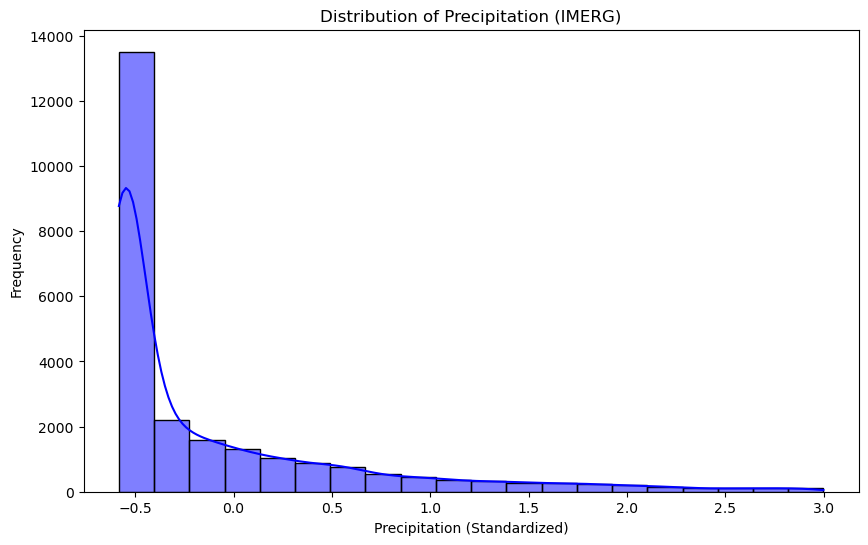

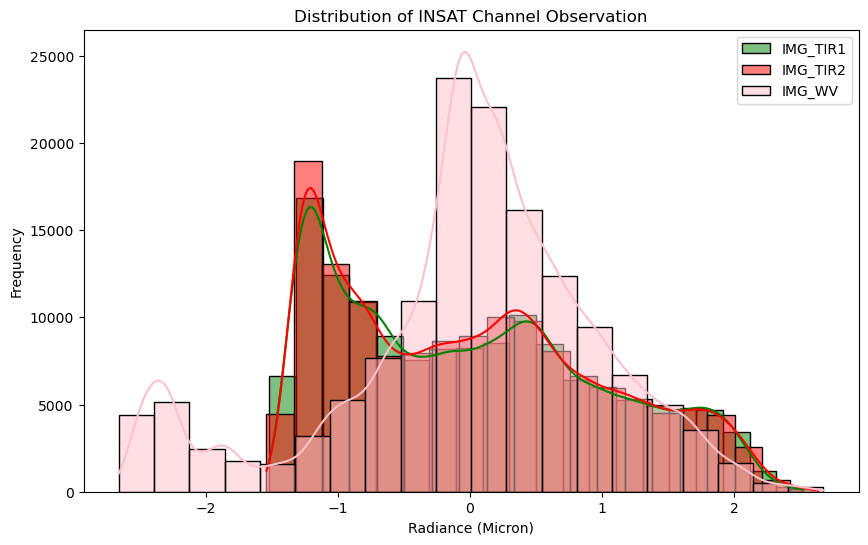

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of IMERG data (precipitation distribution)
plt.figure(figsize=(10, 6))
sns.histplot(imerg_data['precipitationCal'], bins=20, kde=True, color='blue')
plt.title('Distribution of Precipitation (IMERG)')
plt.xlabel('Precipitation (Standardized)')
plt.ylabel('Frequency')
plt.show()

# Visualization of INSAT data (temperature distribution)
plt.figure(figsize=(10, 6))
sns.histplot(insat_train['IMG_TIR1'], bins=20, kde=True, color='green', label='IMG_TIR1')
sns.histplot(insat_train['IMG_TIR2'], bins=20, kde=True, color='red', label='IMG_TIR2')
sns.histplot(insat_train['IMG_WV'], bins=20, kde=True, color='pink', label='IMG_WV')
plt.title('Distribution of INSAT Channel Observation')
plt.xlabel('Radiance (Micron)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [5]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Function to extract temporal features
def extract_temporal_features(data):
    data['year'] = data['time'].dt.year
    data['month'] = data['time'].dt.month
    data['day'] = data['time'].dt.day
    return data

# Function to perform feature engineering for INSAT data
def feature_engineering_insat(insat_data_list):
    scaled_insat_data_list = []
    for insat_train, insat_val, insat_test in insat_data_list:
        # Extract temporal features
        insat_train = extract_temporal_features(insat_train)
        insat_val = extract_temporal_features(insat_val)
        insat_test = extract_temporal_features(insat_test)
        
        # Standardize numerical features
        scaler = StandardScaler()
        scaler.fit(insat_train[['IMG_TIR1', 'IMG_TIR2', 'IMG_WV']])
        insat_train_scaled = scaler.transform(insat_train[['IMG_TIR1', 'IMG_TIR2', 'IMG_WV']])
        insat_val_scaled = scaler.transform(insat_val[['IMG_TIR1', 'IMG_TIR2', 'IMG_WV']])
        insat_test_scaled = scaler.transform(insat_test[['IMG_TIR1', 'IMG_TIR2', 'IMG_WV']])
        
        # Perform PCA for dimensionality reduction
        pca = PCA(n_components=2)
        insat_train_pca = pca.fit_transform(insat_train_scaled)
        insat_val_pca = pca.transform(insat_val_scaled)
        insat_test_pca = pca.transform(insat_test_scaled)
        
        
        scaled_insat_data_list.append((insat_train_pca, insat_val_pca, insat_test_pca))
    
    return scaled_insat_data_list

# Load IMERG data
imerg_data = pd.read_csv("/Users/kunalpathak9826/Desktop/ISRO/Data/IMERG.csv")

# Handling Missing Values
imerg_data.dropna(inplace=True)

# Data Formatting (assuming time is in string format)
imerg_data['time'] = pd.to_datetime(imerg_data['time'])

# Normalization/Standardization (using StandardScaler)
scaler = StandardScaler()
imerg_data[['precipitationCal']] = scaler.fit_transform(imerg_data[['precipitationCal']])

# Outlier Detection/Removal (using Z-score)
imerg_data = imerg_data[(imerg_data['precipitationCal'] - imerg_data['precipitationCal'].mean()) / imerg_data['precipitationCal'].std() < 3]

# Data Splitting (assuming 70% training, 15% validation, and 15% test split)
imerg_train, imerg_test = train_test_split(imerg_data, test_size=0.3, random_state=42)
imerg_val, imerg_test = train_test_split(imerg_test, test_size=0.5, random_state=42)

# Load and preprocess INSAT data
insat_directory = "/Users/kunalpathak9826/Desktop/ISRO/Data/INSAT 31:12:23/CSV Files"
insat_data_list = []

for filename in os.listdir(insat_directory):
    if filename.endswith(".csv"):
        insat_data = pd.read_csv(os.path.join(insat_directory, filename))

        # Handling Missing Values
        insat_data.dropna(inplace=True)

        # Data Formatting (assuming time is in string format)
        insat_data['time'] = pd.to_datetime(insat_data['time'])

        # Outlier Detection/Removal (using Z-score)
        insat_data = insat_data[(insat_data['IMG_TIR1'] - insat_data['IMG_TIR1'].mean()) / insat_data['IMG_TIR1'].std() < 3]
        insat_data = insat_data[(insat_data['IMG_TIR2'] - insat_data['IMG_TIR2'].mean()) / insat_data['IMG_TIR2'].std() < 3]
        insat_data = insat_data[(insat_data['IMG_WV'] - insat_data['IMG_WV'].mean()) / insat_data['IMG_WV'].std() < 3]

        # Data Splitting (assuming 70% training, 15% validation, and 15% test split)
        insat_train, insat_test = train_test_split(insat_data, test_size=0.3, random_state=42)
        insat_val, insat_test = train_test_split(insat_test, test_size=0.5, random_state=42)

        insat_data_list.append((insat_train, insat_val, insat_test))

# Feature engineering for INSAT data
insat_data_list = feature_engineering_insat(insat_data_list)


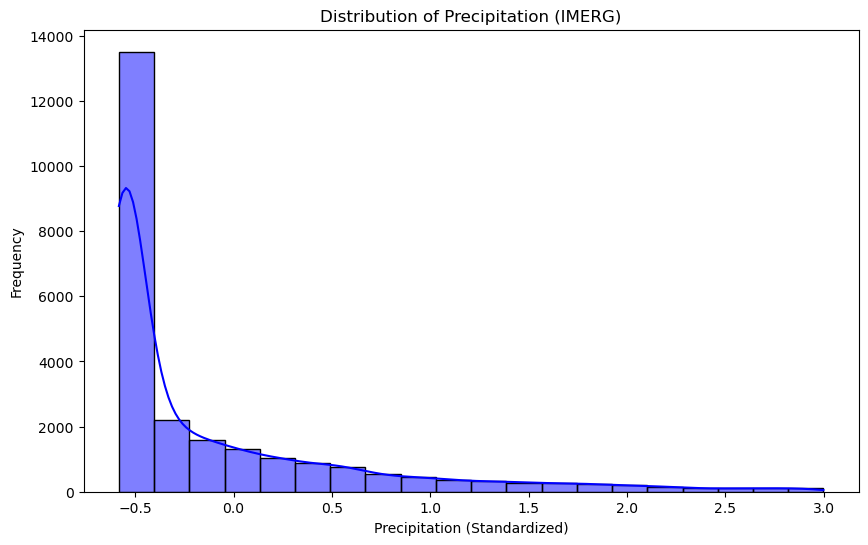

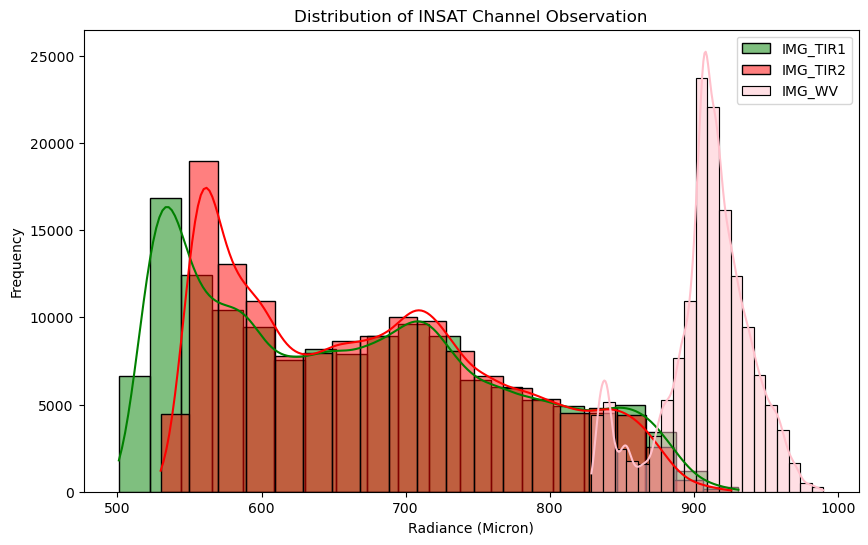

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of IMERG data (precipitation distribution)
plt.figure(figsize=(10, 6))
sns.histplot(imerg_data['precipitationCal'], bins=20, kde=True, color='blue')
plt.title('Distribution of Precipitation (IMERG)')
plt.xlabel('Precipitation (Standardized)')
plt.ylabel('Frequency')
plt.show()

# Visualization of INSAT data (temperature distribution)
plt.figure(figsize=(10, 6))
sns.histplot(insat_train['IMG_TIR1'], bins=20, kde=True, color='green', label='IMG_TIR1')
sns.histplot(insat_train['IMG_TIR2'], bins=20, kde=True, color='red', label='IMG_TIR2')
sns.histplot(insat_train['IMG_WV'], bins=20, kde=True, color='pink', label='IMG_WV')
plt.title('Distribution of INSAT Channel Observation')
plt.xlabel('Radiance (Micron)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [12]:
insat_data_list

[(array([[ 1.94014995,  0.59183841],
         [ 2.90340542,  0.22260634],
         [-1.37012984, -0.09084467],
         ...,
         [-0.91220213, -0.10953126],
         [ 2.0978118 ,  0.09667835],
         [ 0.76621481,  0.62413119]]),
  array([[-0.30065093, -0.02997055],
         [-2.25616284,  0.20978441],
         [-0.40983561, -0.14137985],
         ...,
         [-1.73953002, -0.29003879],
         [-1.98131451, -0.52799999],
         [-1.28310039,  0.44126142]]),
  array([[ 0.72778685,  0.47963537],
         [-2.24219519,  1.29423977],
         [-1.56762234, -0.53807409],
         ...,
         [-0.15973922, -0.41439117],
         [ 1.5770163 ,  0.19572929],
         [ 0.23694914, -0.35744265]])),
 (array([[ 1.21136175,  0.56546689],
         [ 2.81903024,  0.23240442],
         [-0.85556553,  0.2038472 ],
         ...,
         [-0.19198537,  0.48054861],
         [ 2.12783252,  0.17579857],
         [ 0.34557808,  0.32042643]]),
  array([[-1.01242083, -0.37417202],
         [

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Step 1: Define Evaluation Metric
evaluation_metric = 'neg_mean_squared_error'

# Step 2: Split Data for IMERG
X_train_val_imerg, X_test_imerg, y_train_val_imerg, y_test_imerg = train_test_split(imerg_train.drop(columns=['precipitationCal']), imerg_train['precipitationCal'], test_size=0.2, random_state=42)

# Step 3: Split Data for INSAT
X_train_insat, X_val_insat, y_train_insat, y_val_insat = train_test_split(insat_data_list[0][0], insat_data_list[0][1], test_size=0.2, random_state=42)


# Step 4: Choose Models for IMERG and INSAT
models_imerg = {
    'RandomForest': RandomForestRegressor()
}

models_insat = {
    'RandomForest': RandomForestRegressor()
}

# Step 5: Hyperparameter Tuning for IMERG
param_grid_imerg = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
}

best_models_imerg = {}
for name, model in models_imerg.items():
    grid_search_imerg = GridSearchCV(model, param_grid_imerg[name], cv=5, scoring=evaluation_metric)
    grid_search_imerg.fit(X_train_val_imerg, y_train_val_imerg)
    best_models_imerg[name] = grid_search_imerg.best_estimator_

# Step 6: Hyperparameter Tuning for INSAT
param_grid_insat = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
}

best_models_insat = {}
for name, model in models_insat.items():
    grid_search_insat = GridSearchCV(model, param_grid_insat[name], cv=5, scoring=evaluation_metric)
    grid_search_insat.fit(X_train_val_insat, y_train_val_insat)
    best_models_insat[name] = grid_search_insat.best_estimator_

# Step 7: Evaluate Models for IMERG
results_imerg = {}
for name, model in best_models_imerg.items():
    y_pred_imerg = model.predict(X_test_imerg)
    score_imerg = mean_squared_error(y_test_imerg, y_pred_imerg)
    results_imerg[name] = score_imerg

# Step 8: Evaluate Models for INSAT
results_insat = {}
for name, model in best_models_insat.items():
    y_pred_insat = model.predict(X_test_insat)
    score_insat = mean_squared_error(y_test_insat, y_pred_insat)
    results_insat[name] = score_insat

# Step 9: Select Best Models for IMERG and INSAT
best_model_name_imerg = min(results_imerg, key=results_imerg.get)
best_model_imerg = best_models_imerg[best_model_name_imerg]

best_model_name_insat = min(results_insat, key=results_insat.get)
best_model_insat = best_models_insat[best_model_name_insat]

# Step 10: Optionally, Retrain Best Models
best_model_imerg.fit(imerg_train.drop(columns=['precipitationCal']), imerg_train['precipitationCal'])
best_model_insat.fit(insat_data_list[0][0], insat_data_list[0][1])


ValueError: Found input variables with inconsistent numbers of samples: [143724, 30798]

In [22]:
# Assuming insat_data_list is a list of tuples where the first element contains features and the second element contains labels
features_insat = insat_data_list[0][0]
labels_insat = insat_data_list[0][1]

# Check the shapes of features and labels
print("Shape of features for INSAT:", features_insat.shape)
print("Shape of labels for INSAT:", labels_insat.shape)

# If the shapes don't match, you may need to align them
if features_insat.shape[0] != labels_insat.shape[0]:
    # Assuming features and labels need to be aligned by selecting a subset
    min_samples = min(features_insat.shape[0], labels_insat.shape[0])
    features_insat = features_insat[:min_samples]
    labels_insat = labels_insat[:min_samples]

# Now, the shapes should match
print("Updated shape of features for INSAT:", features_insat.shape)
print("Updated shape of labels for INSAT:", labels_insat.shape)

# Proceed with splitting the data
X_train_insat, X_val_insat, y_train_insat, y_val_insat = train_test_split(features_insat, labels_insat, test_size=0.2, random_state=42)


Shape of features for INSAT: (143724, 6)
Shape of labels for INSAT: (30798, 6)
Updated shape of features for INSAT: (30798, 6)
Updated shape of labels for INSAT: (30798, 6)


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split  # Added import statement

# Assuming insat_data_list is a list of tuples where the first element contains features and the second element contains labels
features_insat = insat_data_list[0][0]
labels_insat = insat_data_list[0][1]

# Check the shapes of features and labels
print("Shape of features for INSAT:", features_insat.shape)
print("Shape of labels for INSAT:", labels_insat.shape)

# If the shapes don't match, you may need to align them
if features_insat.shape[0] != labels_insat.shape[0]:
    # Assuming features and labels need to be aligned by selecting a subset
    min_samples = min(features_insat.shape[0], labels_insat.shape[0])
    features_insat = features_insat[:min_samples]
    labels_insat = labels_insat[:min_samples]

# Now, the shapes should match
print("Updated shape of features for INSAT:", features_insat.shape)
print("Updated shape of labels for INSAT:", labels_insat.shape)

# Proceed with splitting the data
X_train_insat, X_val_insat, y_train_insat, y_val_insat = train_test_split(features_insat, labels_insat, test_size=0.2, random_state=42)


# Step 1: Define Evaluation Metric
evaluation_metric = 'neg_mean_squared_error'

# Step 2: Split Data for IMERG
X_train_val_imerg, X_test_imerg, y_train_val_imerg, y_test_imerg = train_test_split(imerg_train.drop(columns=['precipitationCal']), imerg_train['precipitationCal'], test_size=0.2, random_state=42)

# Step 4: Choose Models for IMERG and INSAT
models_imerg = {
    'RandomForest': RandomForestRegressor()
}

models_insat = {
    'RandomForest': RandomForestRegressor()
}

# Step 5: Hyperparameter Tuning for IMERG
param_grid_imerg = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
}

best_models_imerg = {}
for name, model in models_imerg.items():
    grid_search_imerg = GridSearchCV(model, param_grid_imerg[name], cv=5, scoring=evaluation_metric)
    grid_search_imerg.fit(X_train_val_imerg, y_train_val_imerg)
    best_models_imerg[name] = grid_search_imerg.best_estimator_

# Step 6: Hyperparameter Tuning for INSAT
param_grid_insat = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
}

best_models_insat = {}
for name, model in models_insat.items():
    grid_search_insat = GridSearchCV(model, param_grid_insat[name], cv=5, scoring=evaluation_metric)
    grid_search_insat.fit(X_train_val_insat, y_train_val_insat)
    best_models_insat[name] = grid_search_insat.best_estimator_

# Step 7: Evaluate Models for IMERG
results_imerg = {}
for name, model in best_models_imerg.items():
    y_pred_imerg = model.predict(X_test_imerg)
    score_imerg = mean_squared_error(y_test_imerg, y_pred_imerg)
    results_imerg[name] = score_imerg

# Step 8: Evaluate Models for INSAT
results_insat = {}
for name, model in best_models_insat.items():
    y_pred_insat = model.predict(X_test_insat)
    score_insat = mean_squared_error(y_test_insat, y_pred_insat)
    results_insat[name] = score_insat

# Step 9: Select Best Models for IMERG and INSAT
best_model_name_imerg = min(results_imerg, key=results_imerg.get)
best_model_imerg = best_models_imerg[best_model_name_imerg]

best_model_name_insat = min(results_insat, key=results_insat.get)
best_model_insat = best_models_insat[best_model_name_insat]

# Step 10: Optionally, Retrain Best Models
best_model_imerg.fit(imerg_train.drop(columns=['precipitationCal']), imerg_train['precipitationCal'])
best_model_insat.fit(insat_data_list[0][0], insat_data_list[0][1])


Shape of features for INSAT: (143724, 11)
Shape of labels for INSAT: (30798, 6)


ValueError: Found input variables with inconsistent numbers of samples: [143724, 30798]

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd  

# Assuming insat_data_list is a list of tuples where the first element contains features and the second element contains labels
features_insat = insat_data_list[0][0]
labels_insat = insat_data_list[0][1]

# Assuming 'time' is the name of the datetime column in your DataFrame
# Convert 'time' column to pandas datetime format
imerg_train['time'] = pd.to_datetime(imerg_train['time'])

# Extract year, month, day, hour, minute, and second features
imerg_train['year'] = imerg_train['time'].dt.year
imerg_train['month'] = imerg_train['time'].dt.month
imerg_train['day'] = imerg_train['time'].dt.day
imerg_train['hour'] = imerg_train['time'].dt.hour
imerg_train['minute'] = imerg_train['time'].dt.minute
imerg_train['second'] = imerg_train['time'].dt.second

# Drop the original 'time' column if it's no longer needed
imerg_train.drop(columns=['time'], inplace=True)

# Check the shapes of features and labels
print("Shape of features for INSAT:", features_insat.shape)
print("Shape of labels for INSAT:", labels_insat.shape)

# If the shapes don't match, you may need to align them
if features_insat.shape[0] != labels_insat.shape[0]:
    # Assuming features and labels need to be aligned by selecting a subset
    min_samples = min(features_insat.shape[0], labels_insat.shape[0])
    features_insat = features_insat[:min_samples]
    labels_insat = labels_insat[:min_samples]

# Now, the shapes should match
print("Updated shape of features for INSAT:", features_insat.shape)
print("Updated shape of labels for INSAT:", labels_insat.shape)

# Proceed with splitting the data
X_train_insat, X_val_insat, y_train_insat, y_val_insat = train_test_split(features_insat, labels_insat, test_size=0.2, random_state=42)

# Rest of the code remains the same
# Step 1: Define Evaluation Metric
evaluation_metric = 'neg_mean_squared_error'

# Step 4: Choose Models for IMERG and INSAT
models_imerg = {
    'RandomForest': RandomForestRegressor()
}

models_insat = {
    'RandomForest': RandomForestRegressor()
}

# Step 5: Hyperparameter Tuning for IMERG
param_grid_imerg = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
}

best_models_imerg = {}
for name, model in models_imerg.items():
    grid_search_imerg = GridSearchCV(model, param_grid_imerg[name], cv=5, scoring=evaluation_metric)
    grid_search_imerg.fit(X_train_val_imerg, y_train_val_imerg)
    best_models_imerg[name] = grid_search_imerg.best_estimator_

# Step 6: Hyperparameter Tuning for INSAT
param_grid_insat = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
}

best_models_insat = {}
for name, model in models_insat.items():
    grid_search_insat = GridSearchCV(model, param_grid_insat[name], cv=5, scoring=evaluation_metric)
    grid_search_insat.fit(X_train_val_insat, y_train_val_insat)
    best_models_insat[name] = grid_search_insat.best_estimator_

# Step 7: Evaluate Models for IMERG
results_imerg = {}
for name, model in best_models_imerg.items():
    y_pred_imerg = model.predict(X_test_imerg)
    score_imerg = mean_squared_error(y_test_imerg, y_pred_imerg)
    results_imerg[name] = score_imerg

# Step 8: Evaluate Models for INSAT
results_insat = {}
for name, model in best_models_insat.items():
    y_pred_insat = model.predict(X_test_insat)
    score_insat = mean_squared_error(y_test_insat, y_pred_insat)
    results_insat[name] = score_insat

# Step 9: Select Best Models for IMERG and INSAT
best_model_name_imerg = min(results_imerg, key=results_imerg.get)
best_model_imerg = best_models_imerg[best_model_name_imerg]

best_model_name_insat = min(results_insat, key=results_insat.get)
best_model_insat = best_models_insat[best_model_name_insat]

# Step 10: Optionally, Retrain Best Models
best_model_imerg.fit(imerg_train.drop(columns=['precipitationCal']), imerg_train['precipitationCal'])
best_model_insat.fit(insat_data_list[0][0], insat_data_list[0][1])


KeyError: 'time'